# PART 1 - Read, clean and show data 

Read and Clean data, check for missing values and outliers

Four databases are provided, each corresponding to a Senvion MM82 wind turbine with nominal Rated power of 2050 kW.

Namely R80711, R80736, R80721 and R80790.
Choose your turbine dataset.

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autotime

time: 345 µs (started: 2024-04-11 17:08:24 +02:00)


In [2]:
from windml.core.functions import load_one

data_dir = Path.cwd().parent.parent / 'Data Turbines - enriched'
turbine_name = 'R80711'
turbine_csv_file = Path(data_dir, f'{turbine_name}.csv')

df = load_one(turbine_csv_file)
df = df.sample(1000)

Loading time: 1.35 seconds.
Memory usage: 65.67 MB.
261812 Lines found.
time: 4.72 s (started: 2024-04-11 17:08:24 +02:00)


<Axes: xlabel='Date_time'>

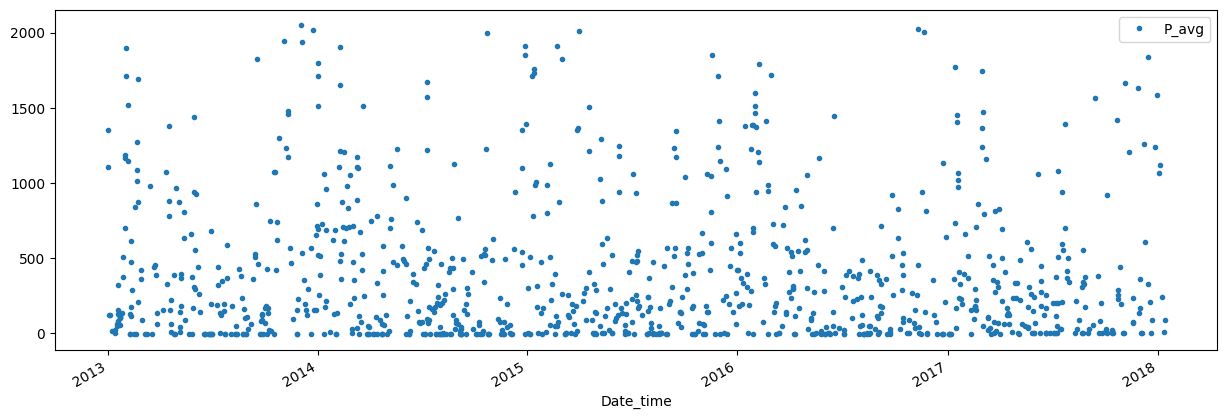

time: 467 ms (started: 2024-04-11 17:08:29 +02:00)


In [3]:
color_pal = sns.color_palette()
df.plot(style='.', y='P_avg', figsize=(15,5), color=color_pal[0])

## 1.1 Check for emtpy features

Preliminary check to locate and remove empty columns. 
**Conclusion** There is no empty column, so we can keep all features.

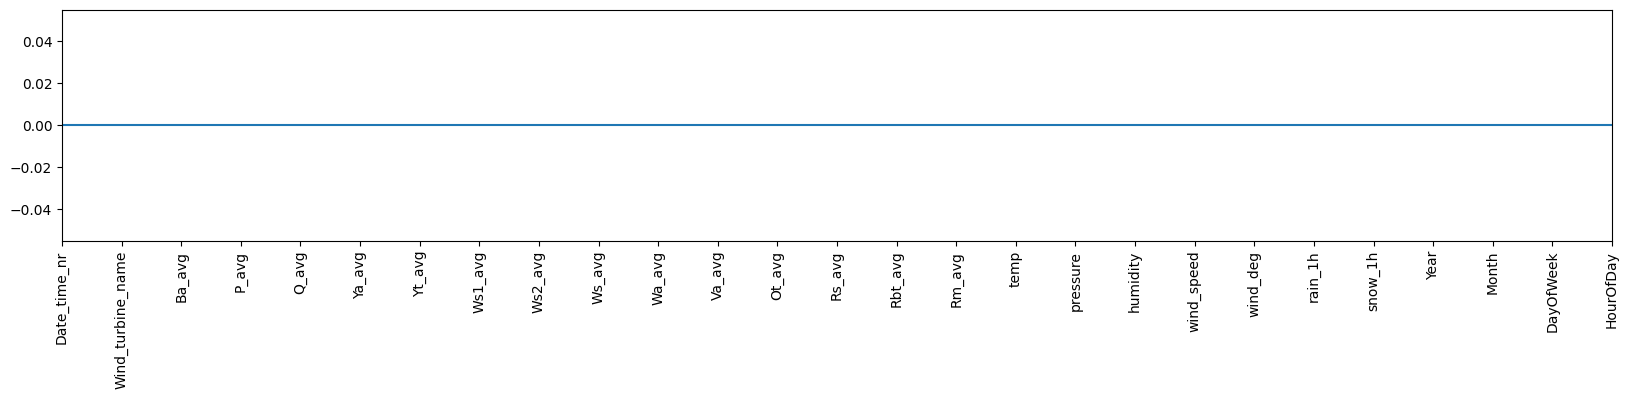

time: 389 ms (started: 2024-04-11 17:08:30 +02:00)


In [4]:
plt.figure(figsize=(20,3))
plt.plot(df.isnull().sum(axis = 0))
plt.xticks(rotation=90)
plt.margins(x=0)
plt.show()

## 1.2 Check uniformity of Database with respect to month, day and hour

Preliminary check to analyse the distribution and uniformity of data over time. Often database could be incomplete or sparse. **Conclusion** The distribution of data is uniform.

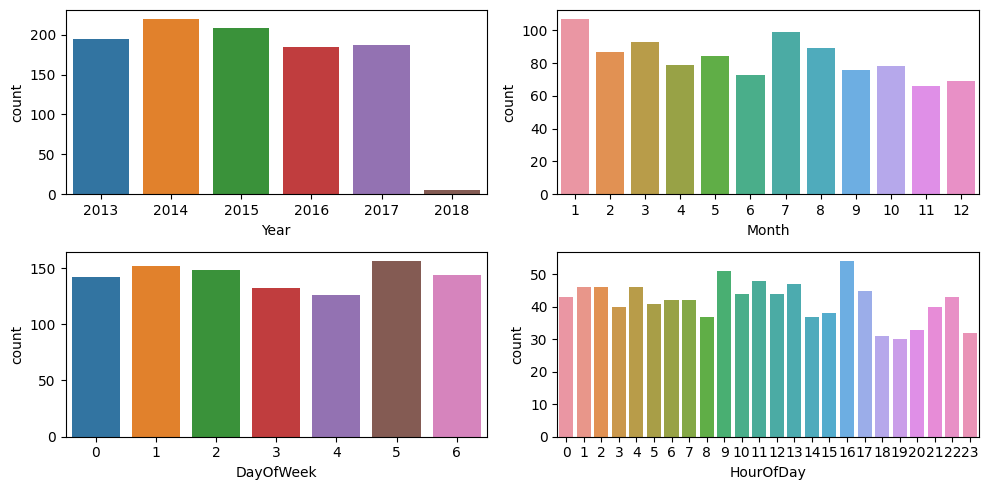

time: 1.07 s (started: 2024-04-11 17:08:30 +02:00)


In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
sns.countplot(x='Year', data=df, ax=ax[0,0])
sns.countplot(x='Month', data=df, ax=ax[0,1])
sns.countplot(x='DayOfWeek', data=df, ax=ax[1,0])
sns.countplot(x='HourOfDay', data=df, ax=ax[1,1])

plt.tight_layout()

## 1.3 Exploratory Data Analysis (EDA)

Check distribution of numerical (non time-related) database entries for visual outliers detection.

In [6]:
# Plot distribution for each column
# Let us exclude columns which are not relevant:
#   - 'Date_time', 
#   - 'Date_time_nr',
#   - 'Wind_turbine_name',
#   - 'Year',
#   - 'Month', 
#   - 'DayOfWeek', 
#   - 'HourOfDay'

tmp_df = df.drop(columns=['Date_time', 'Date_time_nr', 'Wind_turbine_name', 
                          'Year', 'Month', 'DayOfWeek', 'HourOfDay'])

ncols = 6
nrows = 4

fig, ax = plt.subplots(ncols, nrows, figsize=(16, 8))

for cc, column in enumerate(tmp_df.columns):

    cc_ax = ax[cc//nrows, cc%nrows]
    cc_ax.text(x=0.05, y=.75, s=column, fontsize=12, transform=cc_ax.transAxes)
    
    # For categorical data
    if tmp_df[column].dtype == 'object':  
        sns.countplot(x=column, data=df, ax=cc_ax)

    # For numerical data
    else:  
        sns.histplot(tmp_df[column], kde=True, ax=cc_ax)


KeyError: "['Date_time'] not found in axis"

time: 2 s (started: 2024-04-11 17:08:31 +02:00)


## 1.4 Find univariate outliers using box plots

### Pitch_angle (Ba_avg)
The pitch angle refers to the angle between the plane of the rotor blade and the oncoming wind. It's a critical parameter for controlling the operation and efficiency of wind turbines. Its values are typically of a few degrees, although at high wind speeds, the pitch angle is increased to reduce the rotor speed and prevent damage to the turbine. 

**Conclusions**
- Discretization issue with 'Ba_avg' -> introducing 'rounded_Ba_avg'
- Removing outliers (keeping only -5 < Ba < 5)

In [ ]:
import plotly.express as px

px.box(df, y="Ba_avg")

In [ ]:
# Remove all entries with too large pitching angle ( -5 < Ba < 5 )

copy_df = df.loc[ ( df.Ba_avg > -5. ) & ( df.Ba_avg < 5. ) ]
sns.histplot( df.Ba_avg, kde=True, color='skyblue', bins=1000 )
print(f'Removing {(1-len(copy_df)/len(df))*100:2.2f}% of the lines,')
print(f'{len(df)-len(copy_df)} rows were removed')

In [ ]:
# Discretization issue with Ba_avg
df['Ba_avg'].value_counts()

In [ ]:
# Round Ba
num_decimal_places = 6
df['rounded_Ba_avg'] = df['Ba_avg'].round(num_decimal_places)
df['rounded_Ba_avg'].value_counts()

sns.histplot( df.rounded_Ba_avg, kde=True, color='skyblue', bins=1000 )

### 2.2 Auto Regression Forecast

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



In [ ]:
(merged_df['E_avg'] - merged_df['pred_E_avg']).sum()

In [ ]:
# Distribution of wind_speed
fig, ax = plt.subplots( 1, 2, figsize=(10, 5) )

sns.histplot(
    df.wind_speed, 
    kde=True, 
    color='skyblue',
    ax=ax[0])
ax[1].plot(df.wind_speed, '+', ls='')

# PART 3: Machine Learning

# Rotor RPM 

- The Rotor RPM is an important factor in a wind turbine’s power output 
- The rotor is sometimes connected to a gearbox to convert a relatively low rotor rpm to a high rpm useful for power generation. 
- The figure below shows the relationship between rotor rpm and Power
- Positively correlated

In [ ]:
# Rotor RPM 
# Rs_avg


fig, ax = plt.subplots( 1, 2, figsize=(10, 5) )

sns.histplot(
    df.Rs_avg, 
    kde=True, 
    color='skyblue',
    ax=ax[0])

ax[1].plot(df.Rs_avg, df.Q_avg, '+', ls='')
ax[1].set_ylabel('Q_avg')
ax[1].set_xlabel('Rs_avg (rpm)')


# Pitch Angle

- When the wind speed and power output become high, the turbine control system pitches (turns) the rotor blades out of the wind
- Under extreme conditions, the pitch angle is utilized to minimize or stall the power production of a wind turbine
- The plot below depicts the relationship between each blade pitch angle and Active Power
- Negative correlation

In [ ]:
fig, ax = plt.subplots( 1, 2, figsize=(10, 5) )

sns.histplot(
    df.Ba_avg, 
    kde=True, 
    color='skyblue',
    ax=ax[0])

ax[1].plot(df.Ba_avg, df.Q_avg, '+', ls='')
ax[1].set_ylabel('Q_avg')
ax[1].set_xlabel('Ba_avg (deg)')


In [ ]:
# Distribution of Power
sns.histplot(df.Q_avg, kde=True, color='skyblue').set_title('Distribution of Q_avg')

# Test for normality on positive Q values
The KS Statistic in the Kolmogorov-Smirnov (K-S) test measures the maximum distance between the empirical cumulative distribution function (ECDF) of the sample data and the cumulative distribution function (CDF) of the reference distribution (in this case, a normal distribution). Essentially, it quantifies the largest discrepancy between the observed distribution of your sample data and the expected distribution if the null hypothesis were true.

## Result

Q_avg - KS Statistic: 0.9731, P-value: 0.0000 

A large KS Statistic value suggests a significant deviation between the sample distribution and the reference distribution.

A p-value significantly less than 0.05 leads to reject the null hypothesis: the data do not come from a normal distribution. 


In [ ]:
import math
from scipy.stats import kstest

# Select postitive values
positive_Q_val = df.loc[ df.Q_avg > 0 ].Q_avg.values

# Perform the Kolmogorov-Smirnov test for normality on the uniformly distributed data
ks_statistic, p_value = kstest(positive_Q_val, 'norm')

print(f"Q_avg - KS Statistic: {ks_statistic:.4f}, P-value: {p_value:.4f}")

# MULTIVARIATE ANALYSIS

In [ ]:
# WIND-POWER curve

sns.scatterplot(
    x=df.wind_speed,
    y=df.Q_avg, 
    alpha=0.05)

# ROSE WIND analysis

- Most wind comes in from the S-W direction
- Stronger wind comes in form the S-W direction

In [ ]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create wind speed and direction variables

ax = WindroseAxes.from_ax()
ax.contourf(
    df.Wa_avg, 
    df.wind_speed, 
    normed=True,
    bins=np.arange(0, 20), 
    cmap=cm.hot)
ax.set_legend()


# Feature Correlation and Selection

- Most wind comes in from the S-W direction
- Stronger wind comes in form the S-W direction

In [ ]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap="YlGnBu") 

In [ ]:
# Check highest correlated variables

correlation_matrix['Q_avg'].sort_values()

correlation_threshold = 0.5

most_correlated_variables = correlation_matrix.loc[ 
     ( correlation_matrix['Q_avg'] < -correlation_threshold )
   | ( correlation_matrix['Q_avg'] > correlation_threshold )
    ]['Q_avg'].index.to_list()

most_correlated_variables.remove('Q_avg')
most_correlated_variables

# MACHINE LEARNING

Output of the turbine: 
- rotor torque
- converter torque
- power output

In [ ]:
scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'

In [ ]:
# Separating the target variable 'y' and features 'X'

#X = df.drop('Q_avg', axis=1) # take all but Q_avg
X = df[most_correlated_variables] # take most correlated variables
y = df['Q_avg'].values.reshape(-1, 1)

# Split the dataset into training and testing sets (20% test size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KERNEL RIDGE REGRESSION

- Define the 'laplacian' kernel: a custom kernel based on L1 distance

### Laplacian (L1) vs Gaussian (L2 or RBF) Kernel
The Gaussian or RBF kernel is defined as:
$$ K_{L1}(x, x') = \exp\left(-\gamma \|x - x'\|\right) $$
$$ K_{L2}(x, x') = \exp\left(-\gamma \|x - x'\|^2\right) $$

- Create a pipeline including scaling and kernel
- define a parameter grid to optimize alpha and gamma and kernel

### 
### Kernel Ridge Regression (KRR)
Kernel Ridge Regression combines Ridge Regression (linear least squares with L2-norm regularization) with the kernel trick. The objective function for KRR is:

$$ \min_{w} \|Xw - y\|^2 + \alpha \|w\|^2 $$

Where:
- $X$ is the matrix of input features.
- $w$ is the vector of coefficients.
- $y$ is the vector of target values.
- $\alpha$ is the regularization parameter.

The kernel trick transforms the input space into a higher-dimensional space using a kernel function $K$, allowing for the learning of non-linear relationships. The KRR model in this higher-dimensional space is given by:

$$ f(x) = \sum_{i=1}^{n} \alpha_i K(x, x_i) $$

Where:
- $K(x, x_i)$ is the kernel function evaluating the similarity between the input vector $x$ and a training example $x_i$.
- $\alpha_i$ are the coefficients solved for in the dual space, not to be confused with the regularization parameter.
- $\alpha$ (regularization parameter) controls the amount of regularization and helps prevent overfitting by penalizing large values of $\alpha_i$.
- $\gamma$ is a parameter of certain kernels (e.g., the RBF kernel), controlling the shape of the kernel function and thus the decision boundary.

For the RBF kernel, often used in KRR, the kernel function is defined as:
$$ K(x, x') = \exp\left(-\gamma \|x - x'\|^2\right) $$

The use of $\gamma$ in the RBF kernel controls the spread of the kernel and influences the model's capacity to handle the data's complexity and noise.


In [ ]:
# Example usage
#X = df.drop('Q_avg', axis=1) # take all but Q_avg
X = df[most_correlated_variables] # take most correlated variables
y = df['Q_avg'] #.values.reshape(-1, 1)


model = LinearRegression()
param_grid = {
    'fit_intercept': [True, False],
}

# Generate learning curve data with GridSearchCV
learning_curve_data = create_learning_curve_with_grid_search(X, y, model, param_grid, num_points=5)

# Plotting the learning curve
plot_learning_curve(learning_curve_data)


In [ ]:
from sklearn.linear_model import Ridge


model_poly = Pipeline([
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge())
])

param_grid_poly = {
    'poly__degree': [2, 3, 4],  # Exploring polynomials of degree 2, 3, and 4
    'ridge__alpha': [0.01, 0.1, 1, 10]  # Regularization strength
}


# Generate learning curve data with GridSearchCV
learning_curve_data = create_learning_curve_with_grid_search(X, y, model_poly, param_grid_poly, num_points=5)

# Plotting the learning curve
plot_learning_curve(learning_curve_data)


In [ ]:
from sklearn.kernel_ridge import KernelRidge

model_krr = KernelRidge()

param_grid_krr = {
    'alpha': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear', 'poly', 'rbf'],  # Type of kernel to use
    'gamma': [0.01, 0.1, 1],  # Kernel coefficient for 'rbf' and 'poly'
    'degree': [2, 3]  # Degree for the 'poly' kernel
}

# Generate learning curve data with GridSearchCV
learning_curve_data = create_learning_curve_with_grid_search(X, y, model_krr, param_grid_krr, num_points=5)

# Plotting the learning curve
plot_learning_curve(learning_curve_data)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()

param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Generate learning curve data with GridSearchCV
learning_curve_data = create_learning_curve_with_grid_search(X, y, model_rf, param_grid_rf, num_points=5)

# Plotting the learning curve
plot_learning_curve(learning_curve_data)
